Reference: https://cs231n.github.io/understanding-cnn/

Please note that this notebook uses convolutional neural networks. It would be adapted to use GPU for training.

Used packages:

numpy, matplotlib, sklearn, torch, urllib, PIL, torchvision, tqdm

tqdm is not necesssary, you will just need to remove it from the code. It just allows to follow the progress of a loop when downloading images (to be sure it works).

# Introduction

We often say that neural networks is like a black box: even if they work very well, we can't say how they learned. Indeed, unlike Machine learning tools, it is very difficult to understand how a trained neural network performs classification or regression. On the contrary, it is quite easy to understand the parameters of a linear classifier, or even of a non-linear classifier such as Random Forest.

To illustrate this, let's visualize how SGD and Random Forest algorithms learn how to classify 0s and 1s on MNIST dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

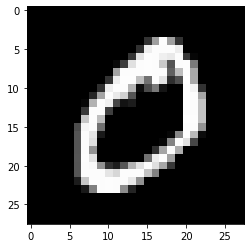

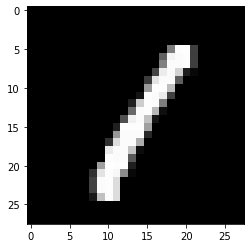

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
X = mnist.data
y = mnist.target
x_01 = X[(y=='0')|(y=='1')]
y_01 = y[(y=='0')|(y=='1')]

plt.figure()
plt.imshow(x_01[(y_01=='0')][0].reshape(28,28), cmap='gray')
plt.figure()
plt.imshow(x_01[(y_01=='1')][0].reshape(28,28), cmap='gray')
plt.show()

## Linear classifier: SGD

With a linear classifier, the classification is based on the sign of a linear function. The decision boundary is easy to visualize, even in high dimensions, because of linearity: it is a list of coefficients (one for each feature). It gives us a direct information on how the classifier has learned: it gives an certain importance to each feature, and this importance can be visualized.


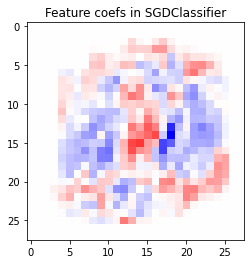

In [3]:
from sklearn.linear_model import SGDClassifier
cl = SGDClassifier()
cl.fit(x_01, y_01)
plt.imshow(cl.coef_.reshape(28,28), cmap='bwr', vmin=-np.abs(cl.coef_).max(), vmax=np.abs(cl.coef_).max())
plt.title('Feature coefs in SGDClassifier')
plt.show()

To classify 0s and 1s on MNIST dataset, we can see that the SGD classifier don't use pixels that are too far from the center of the image. Above, red pixels tend to show that the figure is a 1, and blue pixels tend to show that the figure is a 0.


## Non-linear classifier: Random Forest

In the case of the Random Forest classifier, there is no weight for each feature. However, sklearn package provides a matrix of feature importance (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random%20forest#sklearn.ensemble.RandomForestClassifier.feature_importances_)

The importance of each feature provided is in fact the Gini Importance, or Mean Decrease in Impurity; it is calculated from the frequency of use of the feature among all the branches making up the random forest.

https://medium.com/the-artificial-impostor/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3#e4f0




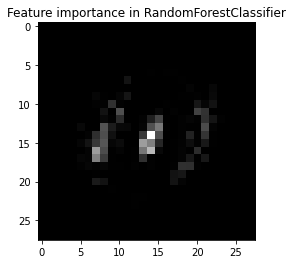

In [4]:
from sklearn.ensemble import RandomForestClassifier
cl = RandomForestClassifier()
cl.fit(x_01, y_01)
plt.imshow(cl.feature_importances_.reshape(28,28), cmap='gray')
plt.title('Feature importance in RandomForestClassifier')
plt.show()

With Random Forest classifier, we also notice that feature that are most important are typically the pixels used to draw either a 0 or a 1 (but not both of them).

In these two basic examples, we showed that it is possible to visualize what the classification function is based on. However, when it comes to neural networks, the function becomes more complex and it is more difficult to visualize what the neural network has learned. What is the role of a particular neuron? of a layer of neurons?

Here we will focus on convolutional networks, which are widely used in image classification.

For the following, we are going to use an AlexNet. On the one hand it will be used to classify images from ImageNet dataset. The advantage is that we will download a pretrained neural network, so there shouldn't be randomness in the results. However, we chose to keep a basic example in order to understand better in the first place, and to show that it is possible for the reader to draw their own conclusion on a network they trained themselves. That's why we will also train and use an AlexNet on MNIST dataset, to classify the 10 figures.

AlexNet is a neural neetworks that splits into 8 layers: first, 5 convolutoins which allow to reduce the size of the image. Then, after a Flatten layer, 3 fully connected layers.

https://en.wikipedia.org/wiki/AlexNet

![Scheme-of-the-AlexNet-network-used.png](attachment:Scheme-of-the-AlexNet-network-used.png)

(image souce: https://www.researchgate.net/publication/320052364/figure/fig1/AS:543136445198336@1506505227088/Scheme-of-the-AlexNet-network-used.png - dimensions will be adapted)


## AlexNet initialization and training

This subsection just deals with imports and trainings needed for the following. We kept the display of both AlexNet if the reader wants to have a look at it. Otherwise, they only should execute this part without looking at it

In [5]:
import torch
model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class MyAlexNet(nn.Module):
    def __init__(self):
      super(MyAlexNet, self).__init__()
      self.features = nn.Sequential(
          nn.Conv2d(1, 8, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
          nn.Conv2d(8, 16, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
          nn.ReLU(inplace=True),
          nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.ReLU(inplace=True),
          nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.ReLU(inplace=True),
          nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
      )

      self.avgpool = nn.AdaptiveAvgPool2d(output_size=(7,7))

      self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Dropout(p=0.5, inplace=False),
          nn.Linear(in_features=1568, out_features=1000, bias=True),
          nn.ReLU(inplace=True),
          nn.Dropout(p=0.5, inplace=False),
          nn.Linear(in_features=1000, out_features=100, bias=True),
          nn.ReLU(inplace=True),
          nn.Linear(in_features=100, out_features=10, bias=True),
      )

    # x represents our data
    def forward(self, x):
      x = self.features(x)

      x = self.avgpool(x)

      x = self.classifier(x)

      # Apply softmax to x
      output = F.log_softmax(x, dim=1)
      return output

net = MyAlexNet()
print(net)


MyAlexNet(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=1568, out_features=1000, bias=True)
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.5, i

In [7]:
x_new = X.reshape(-1, 1, 28, 28)
y_new = y.astype(int)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = [torch.from_numpy(_) for _ in train_test_split(x_new, y_new, shuffle=True)]
x_train, x_test = x_train.float(), x_test.float()
x_train.shape, x_test.shape, y_train.shape, y_test.shape


(torch.Size([52500, 1, 28, 28]),
 torch.Size([17500, 1, 28, 28]),
 torch.Size([52500]),
 torch.Size([17500]))

In [8]:
import torch.optim as optim

criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

batch_size=32

In [9]:
torch.cuda.is_available()

True

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
net = net.to(device)

n_epochs=2
for epoch in range(n_epochs):  # loop over the dataset multiple times
    training_loss = 0.0
    for i in range(x_train.shape[0]//batch_size+1):
        net.train()
        inputs = x_train[batch_size*i:batch_size*(i+1)].to(device)
        labels = y_train[batch_size*i:batch_size*(i+1)].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)#.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        training_loss += loss.item()
        if i % 100 == 100-1:
            net.eval()
            validation_loss = criterion(net(x_test.to(device)), y_test.to(device))
            print('Epoch {}/{}, {}/{}: training_loss: {}, validation_loss: {}'.format(
                epoch, n_epochs,
                i, x_train.shape[0]//batch_size+1,
                training_loss/100, 
                validation_loss
            ))
            training_loss = 0.0

print('Finished Training')
net.to('cpu')
net.eval()

Epoch 0/2, 99/1641: training_loss: 2.0446891385316848, validation_loss: 1.0188801288604736
Epoch 0/2, 199/1641: training_loss: 0.8328973716497421, validation_loss: 0.40641334652900696
Epoch 0/2, 299/1641: training_loss: 0.4716265424713492, validation_loss: 0.22929711639881134
Epoch 0/2, 399/1641: training_loss: 0.3934524806216359, validation_loss: 0.1875736564397812
Epoch 0/2, 499/1641: training_loss: 0.3264140959456563, validation_loss: 0.16697117686271667
Epoch 0/2, 599/1641: training_loss: 0.2855800763517618, validation_loss: 0.1356622576713562
Epoch 0/2, 699/1641: training_loss: 0.23332023598253726, validation_loss: 0.12304503470659256
Epoch 0/2, 799/1641: training_loss: 0.25161560405045746, validation_loss: 0.11660505831241608
Epoch 0/2, 899/1641: training_loss: 0.2118764501810074, validation_loss: 0.10261381417512894
Epoch 0/2, 999/1641: training_loss: 0.18833893729373813, validation_loss: 0.10357441008090973
Epoch 0/2, 1099/1641: training_loss: 0.18139644503593444, validation_lo

MyAlexNet(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=1568, out_features=1000, bias=True)
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.5, i

Let's just have a look on the performance of the trained neural network with its correlation matrix on test data:


In [11]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, net(x_test).detach().numpy().argmax(1))

array([[1709,    0,    1,    1,    0,    0,    2,    0,    1,    0],
       [   0, 1981,    7,    1,    2,    0,    1,    1,    9,    0],
       [   1,    3, 1721,    2,    2,    0,    0,   11,    2,    3],
       [   1,    1,   11, 1693,    0,    4,    0,    8,    3,    6],
       [   0,    7,    2,    0, 1644,    0,    2,    0,    1,    6],
       [   3,    1,    2,    9,    1, 1631,    9,    0,    6,    6],
       [  15,    2,    0,    0,    6,    0, 1680,    0,    1,    0],
       [   1,    6,    6,    0,    5,    1,    0, 1815,    2,   15],
       [   7,    9,   13,    4,    1,    6,    7,    3, 1639,   18],
       [   1,    2,    0,    6,   19,    2,    0,    8,    4, 1678]])

# Visualization neural activations

A basic approach consists on trying to visualize the activation of each neuron layer in relation to the input. For example, we can look at what the first layer of the trained AlexNet returns, to understand how the first convolutional layer acted.

More images about this method can be found in *Visualizing and Understanding Convolutional Networks* (https://arxiv.org/pdf/1311.2901.pdf)

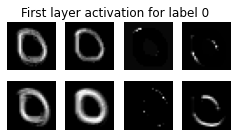

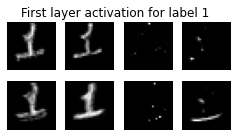

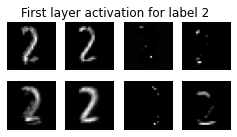

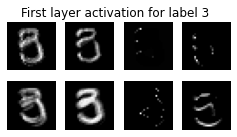

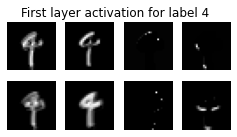

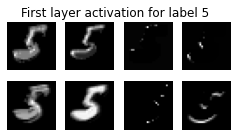

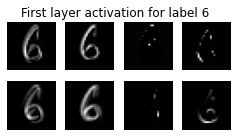

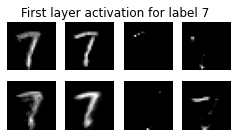

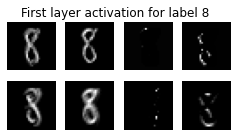

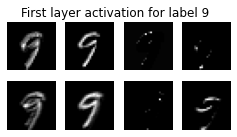

In [12]:
for _ in range(10):
    i = np.random.choice(np.where(y_test==_)[0])
    image = x_test[i:i+1]
    activation = net.features[:2](image).detach().numpy()
    fig, axs = plt.subplots(2,4, figsize=(4,2))
    for i in range(8):
        axs[i//4, i%4].imshow(activation[0,i], cmap='gray', vmin=0, vmax=activation[0,i].max())
        axs[i//4, i%4].axis('off')
    fig.suptitle('First layer activation for label {}'.format(_))
    plt.show()

This seems quite intuitive for the first layer. In the MNIST case, we notive that depending on the input, the output of this first layer will more or less amplify certain parts of the drawing. We also notive that for some input images, there are convolutions which activate almost no neuron. We can therefore understand the filter effect of a convolutional layer.

Still, this approach seems limited: whenever we try to visualize the activation of the deeper convolutional layers, it is very difficult to see anything.

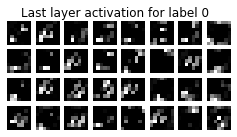

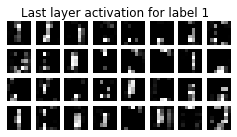

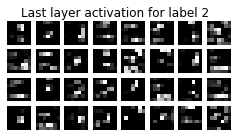

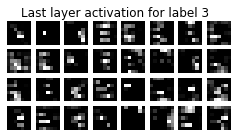

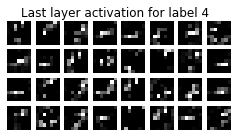

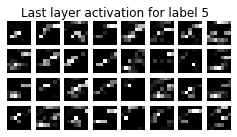

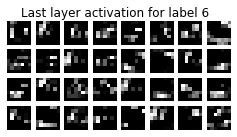

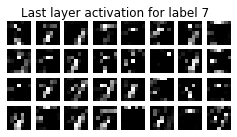

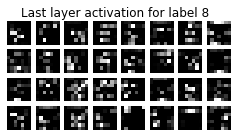

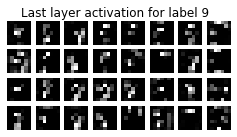

In [13]:
for _ in range(10):
    i = np.random.choice(np.where(y_test==_)[0])
    image = x_test[i:i+1]
    activation = net.features(image).detach().numpy()
    fig, axs = plt.subplots(4,8, figsize=(4,2))
    for i in range(32):
        axs[i//8, i%8].imshow(activation[0,i], cmap='gray', vmin=0, vmax=activation[0,i].max())
        axs[i//8, i%8].axis('off')
    fig.suptitle('Last layer activation for label {}'.format(_))
    plt.show()

We can also try to average the activation for same labelled inputs, to be sure that we don't have a special case; This is good looking when visualizing the activation of the first convolutional layer, but we can't see anything when visualizing the activation of teh last convolutional layer.

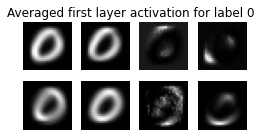

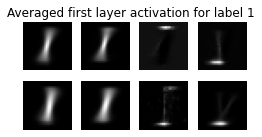

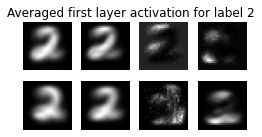

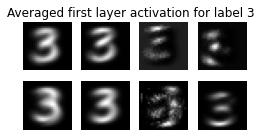

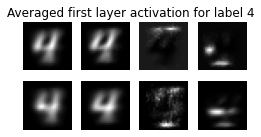

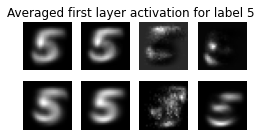

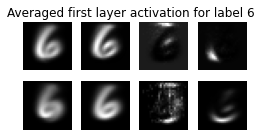

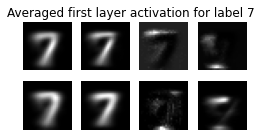

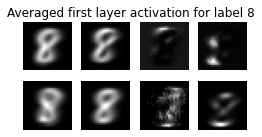

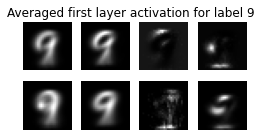

In [14]:
for _ in range(10):
    i = np.random.choice(np.where(y_test==_)[0], 1000)
    image = x_test[i]
    activation = net.features[:2](image).detach().numpy()
    activation = activation.mean(0)
    fig, axs = plt.subplots(2,4, figsize=(4,2))
    for i in range(8):
        axs[i//4, i%4].imshow(activation[i], cmap='gray', vmin=0, vmax=activation[i].max())
        axs[i//4, i%4].axis('off')
    fig.suptitle('Averaged first layer activation for label {}'.format(_))
    plt.show()

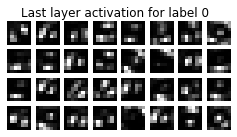

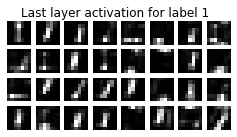

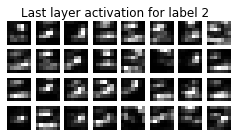

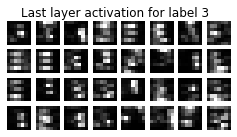

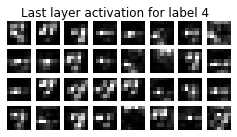

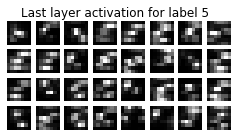

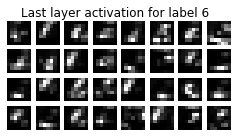

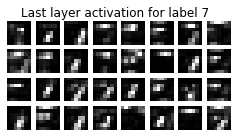

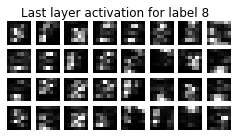

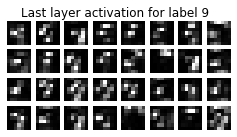

In [15]:
for _ in range(10):
    i = np.random.choice(np.where(y_test==_)[0], 1000)
    image = x_test[i]
    activation = net.features(image).detach().numpy()
    activation = activation.mean(0)
    fig, axs = plt.subplots(4,8, figsize=(4,2))
    for i in range(32):
        axs[i//8, i%8].imshow(activation[i], cmap='gray', vmin=0, vmax=activation[i].max())
        axs[i//8, i%8].axis('off')
    fig.suptitle('Last layer activation for label {}'.format(_))
    plt.show()

Let's do the same on AlexNet pretrained on ImageNet. We need an image: let's download a dog image from the internet, and let's see what's the neural activation when we apply this image to the neural network.

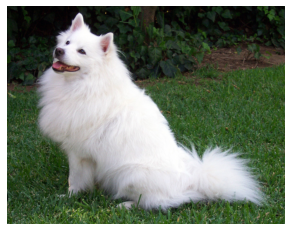

In [16]:
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_dog = input_tensor.unsqueeze(0)

plt.imshow(np.array(input_image))
plt.axis('off')
plt.show()

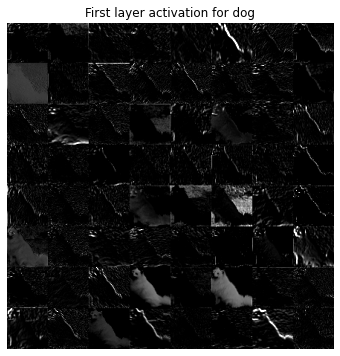

In [17]:
activation = model.features[:2](input_dog).detach().numpy()
im = np.zeros((55*8, 55*8))
for _ in range(64):
    i, j = _//8, _%8
    im[55*i:55*(i+1), 55*j:55*(j+1)] = activation[0,_]
plt.figure(figsize=(6,6))
plt.imshow(im, cmap='gray', vmin=0, vmax=activation[0,i].max())
plt.title('First layer activation for dog')
plt.axis('off')
plt.show()

It seems a bit difficult to really understand what all convolutions do. Some seem to detect the border between the dog and the background. Others tend to detect either the foreground or teh background. But we don't know how this information is used to classify the image, especially since this classification is not yet done at this depth of the network. We can summarize that this convolutional layer selects some features that have benn proved useful for classification during training.

Is it still possible to get information from the activation of the second layer?

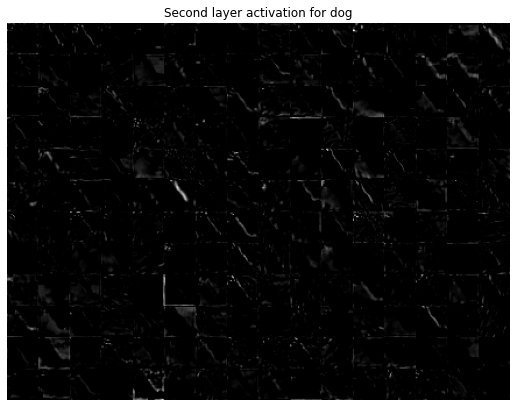

In [18]:
activation = model.features[:5](input_dog).detach().numpy()
im = np.zeros((27*12, 27*16))
for _ in range(192):
    i, j = _//16, _%16
    im[27*i:27*(i+1), 27*j:27*(j+1)] = activation[0,_]
plt.figure(figsize=(9,9))
plt.imshow(im, cmap='gray', vmin=0, vmax=activation[0,i].max())
plt.title('Second layer activation for dog')
plt.axis('off')
plt.show()

Second convolutional layer activation is already much less visually comprehensible.

And when it goes to the last convolutional layer activation, we can't understand anything:

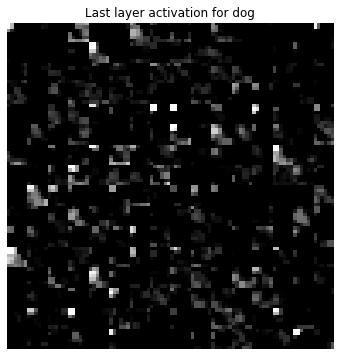

In [19]:
activation = model.features(input_dog).detach().numpy()
im = np.zeros((6*16, 6*16))
for _ in range(256):
    i, j = _//16, _%16
    im[6*i:6*(i+1), 6*j:6*(j+1)] = activation[0,_]
plt.figure(figsize=(6,6))
plt.imshow(im, cmap='gray', vmin=0, vmax=activation[0,i].max())
plt.title('Last layer activation for dog')
plt.axis('off')
plt.show()

It looks like noise... except that it is not. Each pixel above can be seen as a feature selected by the convolutional part of AlexNet. Then, these features will be used in the Multi-Layer Perceptron part.

We will see that some information can be extracted from this selection of features. We will visualize them in the "Embedding the codes with t-SNE" section. But before that, we will continue the visualization of convolutions. We have seen that it is possible to visualize the activation of a convolutional layer on an image, this allows us to see which areas of an image are activated by a convolution. Now we will visualize directly a convolution, without the need of any input image. Then we will try to show that both approaches are complementary.

# Visualizing convolution weights


By visualizing the weights of a convolutional layer, one can hope to understand the function of a layer, in the same way that one can understand the decision of an SGD classifier simply from the weights it has learned: can we decode information from the parameters of a convolution?

Let's have a look at the first convolutional layer weights on the AlexNet trained on the MNIST dataset:

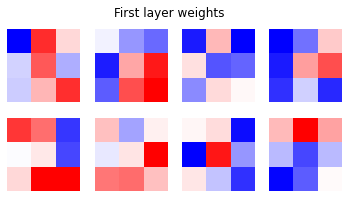

In [20]:
conv = net.features[0]
weights = conv.weight.detach().numpy() # shape: 8 x 1 x 3 x 3
weights = weights[:,0,:,:]
fig, axs = plt.subplots(2,4,figsize=(6,3))
for _, w in enumerate(weights):
    i, j = _//4, _%4
    axs[i,j].imshow(w, cmap='bwr', vmin=-np.abs(w).max(), vmax=np.abs(w).max())
    axs[i,j].axis('off')
fig.suptitle('First layer weights')
plt.show()

There are typically several types of convolutions. The reader is reminded that the training was done locally, so it is not sure that you will visualizing each phenomenon. But it is a good exercise to look for it on their own local example.

For some convolutions, we can draw an axis of antisymmetry, meaning that we can draw a line that separates the blue colors (negative weights) and red colors (positive weights).

One can understand that the effect of this type of convolution is to detect borders on a particular axis, like a differentiation. To be sure of it, we can display again the average activation of this layer on a 0, which as the advantage of having borders on all axis.


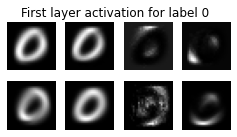

In [21]:
i = np.random.choice(np.where(y_test==0)[0], 1000)
image = x_test[i]
activation = net.features[:2](image).detach().numpy().mean(0)
fig, axs = plt.subplots(2,4, figsize=(4,2))
for i in range(8):
    axs[i//4, i%4].imshow(activation[i], cmap='gray', vmin=0, vmax=activation[i].max())
    axs[i//4, i%4].axis('off')
fig.suptitle('First layer activation for label 0')
plt.show()

Can you see which convolutions detect borders? A good exercise is to *associate* the activation and the convolution weights to have a better understanding on their effect.

You may also seee that if we display the average activation of a 7, some of these convolutions will amplify either the horizontal or the diagonal lines.


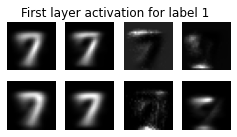

In [22]:
i = np.random.choice(np.where(y_test==7)[0], 1000)
image = x_test[i]
activation = net.features[:2](image).detach().numpy().mean(0)
fig, axs = plt.subplots(2,4, figsize=(4,2))
for i in range(8):
    axs[i//4, i%4].imshow(activation[i], cmap='gray', vmin=0, vmax=activation[i].max())
    axs[i//4, i%4].axis('off')
fig.suptitle('First layer activation for label 1')
plt.show()

When there is no apparent symmetry on weights, it is more complicated to understand the convolution; it is no longer a differentiation.


We can look for differentation convolutions fore the pretrained AlexNet on ImageNet. Base on our findings on the activation of the first convolutional layer, one would expect to have such convolutions when the activation is a boundary.

The representation of weights is slightly different: it is colored. Indeed, on the first layer, it is quite natural to visualize the convolution in 3 colors, because each convolution acts differently on the 3 images (RGB) in the input. Thus, the neutral color is no longer white, but gray.

The other graphical solution is to visualize the 3 colors separately. This will be done later.


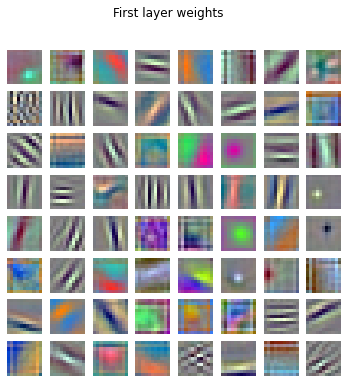

In [23]:
conv = model.features[0]
weights = conv.weight.detach().numpy() # shape: 64 x 3 x 11 x 11
fig, axs = plt.subplots(8,8,figsize=(6,6))
for _, w in enumerate(weights):
    i, j = _//8, _%8
    w = (w/np.abs(w).max() + 1)/2
    axs[i,j].imshow(w.transpose(1,2,0))
    axs[i,j].axis('off')
fig.suptitle('First layer weights')
plt.show()

We can try to compare this visualization with the previous one. Let's take for example a convolution that activated borders on the dog picture, and try to guess how it did it.

Let's pick the 63rd convolution in this layer

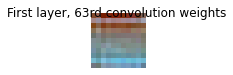

In [24]:
conv = model.features[0]
weights = conv.weight.detach().numpy() # shape: 64 x 3 x 11 x 11
plt.figure(figsize=(1,1))
w = weights[62]
w = (w/np.abs(w).max() + 1)/2
plt.imshow(w.transpose(1,2,0))
plt.axis('off')
plt.suptitle('First layer, 63rd convolution weights')
plt.show()

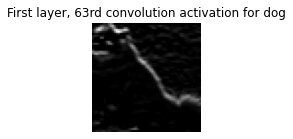

In [25]:
activation = model.features[:2](input_dog).detach().numpy()
im = np.zeros((55*8, 55*8))
plt.figure(figsize=(2,2))
plt.imshow(activation[0,62], cmap='gray', vmin=0, vmax=activation[0,62].max())
plt.title('First layer, 63rd convolution activation for dog')
plt.axis('off')
plt.show()

Let's try to explain this activation using convolution weights. To do this, we will decompose the image into its three RGB filters, and decompose the convolution weights for these three colors.

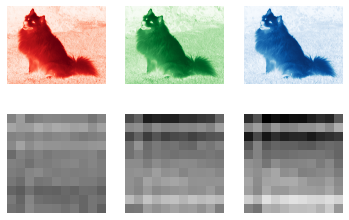

In [26]:
w = weights[62]
fig, axs = plt.subplots(2,3,figsize=(6,4))
for color in range(3):
    axs[0, color].imshow(np.array(input_image)[:,:,color], cmap=['Reds', 'Greens', 'Blues'][color])
    axs[0, color].axis('off')
    axs[1, color].imshow(w[color], cmap='gray', vmin=-np.abs(w).max(), vmax=np.abs(w).max())
    axs[1, color].axis('off')


Around the border detected on the image, we notice several things. First, the border is visible on the three colors; this is not necessarily the case, but it makes it easier to detect it. Moreover, the border around the dog's muzzle (its head) is more visible on the blue and green images than on the red image.

The convolution filter does not act exactly in the same way on the 3 colors. It is relatively homogeneous (thus without differentiation effect) for the red color, but for the blue and green colors, it seems to act as a differentiation on the vertical axis, on the same direction.

This explains what this filter detects: it detects the blue and green borders, rather on a horizontal axis.

As soon as the border is vertical, it shouldn't be detected by the filter. It would be enough to rotate the image by 90° to check our interpretation.


In [27]:
input_dog_rot90 = input_dog.rot90(dims=(2,3))

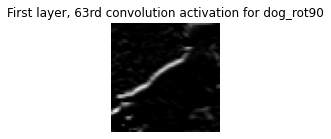

In [28]:
activation = model.features[:2](input_dog_rot90).detach().numpy()
im = np.zeros((55*8, 55*8))
plt.figure(figsize=(2,2))
plt.imshow(activation[0,62], cmap='gray', vmin=0, vmax=activation[0,62].max())
plt.title('First layer, 63rd convolution activation for dog_rot90')
plt.axis('off')
plt.show()

The filter still activates the border of the dog's back. It is logical: it is not a vertical border. However, the muzzle border is now vertical, and... we can't see it. The interpretation seems correct: such a filter detects a border, except if this border is nearly vertical.

Now, let's look at another type of convolutions. The 38th acts completly differently, since it seems to have recognized the background of the image.

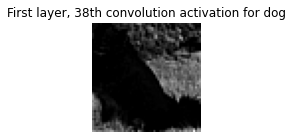

In [29]:
activation = model.features[:2](input_dog).detach().numpy()
im = np.zeros((55*8, 55*8))
plt.figure(figsize=(2,2))
plt.imshow(activation[0,37], cmap='gray', vmin=0, vmax=activation[0,37].max())
plt.title('First layer, 38th convolution activation for dog')
plt.axis('off')
plt.show()

We can try to visualize the three convolutions in color, like we did before, to understand how a convolution can separate these colors.

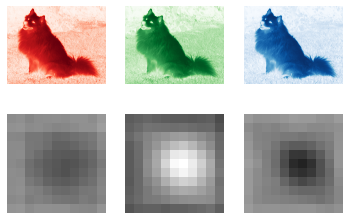

In [30]:
w = weights[37]
fig, axs = plt.subplots(2,3,figsize=(6,4))
for color in range(3):
    axs[0, color].imshow(np.array(input_image)[:,:,color], cmap=['Reds', 'Greens', 'Blues'][color])
    axs[0, color].axis('off')
    axs[1, color].imshow(w[color], cmap='gray', vmin=-np.abs(w).max(), vmax=np.abs(w).max())
    axs[1, color].axis('off')


We understand that this convolution layer is specialized in the detection of green, and the absence of blue (in the center of the convolution, positive weight on green, negative weight on blue, and even slightly negative weight on red). This is why the white regions of the dog are not activated by this filter, but the green regions are activated.

That explains why it is possible to extract foreground/background of an image using convolutional neural networks, like in *Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps* (https://arxiv.org/pdf/1312.6034.pdf)

This type of filter was difficult to see in the simple case of the network trained on MNIST. The main reason is that here, the first convolutional layer contains much more information: the kernels are 11x11 in size, and act on 3-colored images. So filters can be more diversified here.


With the two previous methods, it is possible to understand the effect of a layer of convolutional neurons. However, the understanding is quite limited. As soon as there are more than 3 colors in input (generally, this is the case in all convolutional layers except the first one), the visualization is more delicate, thus the comprehension is hard.

Moreover, the visualization of the layer activation and convolutional weights is possible for all layers, but it remains quite difficult to understand them when you go deeper in the neural network.

# Selection of images that maximize neuron activation

To try to better understand the activation of a neuron, we can take another point of view. We can try to look for images that specifically activate a neuron. We will see that it allows to understand deeper neurons in the neural network.

The idea is to test the activation of a neuron on a large quantity of images, then to display the images that have maximized this activation. Visually, we could then try to understand the common point between these images.

One could hope that it would allow us to understand the activations that were incomprehensible with the previous methods, i.e. the activations for the deep layers of the network.

Let's take, for example, the vector obtained after having passed all the convolutional layers and the Flatten of the network. We saw that this vector is not understandable with previous methods. Let's try to see which MNIST images best activate certain neurons of this layer.

In [31]:
activation = net.classifier[0](net.avgpool(net.features(x_test))).detach().numpy()
activation.shape

(17500, 1568)

For each image, we get the layer of 1568 neurons more or less activated. We can think of it as a vector of features of dimension 1568. This idea is developped in *Do Convnets Learn Correspondence?* (https://proceedings.neurips.cc/paper/2014/file/b86e8d03fe992d1b0e19656875ee557c-Paper.pdf), where they call these features as *convnet features* learned by the neural network.

Here we will see the results for several random intermediate features, as it depends on the local training of the AlexNet.

Usually, one can notice that some are already specialized in the recognition of a particular digit. This can be explained because the MNIST problem is quite simple for this kind of neural networks. In some cases, the recognition is less clear. They do not recognize a particular digit; on the contrary, they can recognize several digits that are similar in a certain way, for example rather curved digits, or on the contrary, digits whose writing has angles.

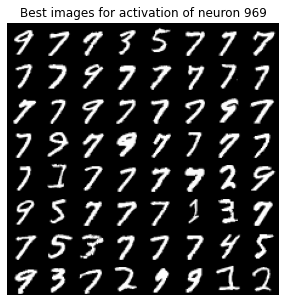

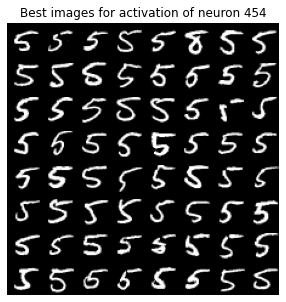

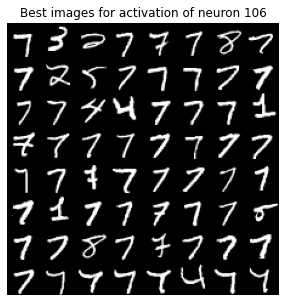

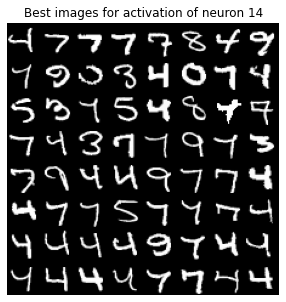

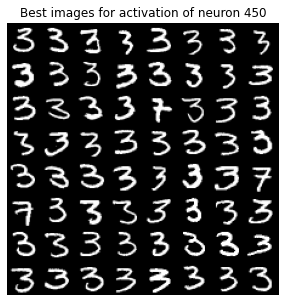

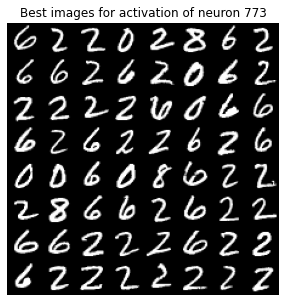

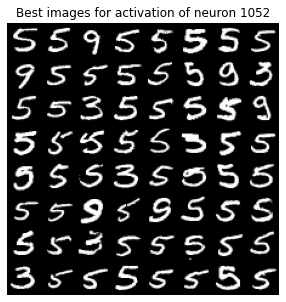

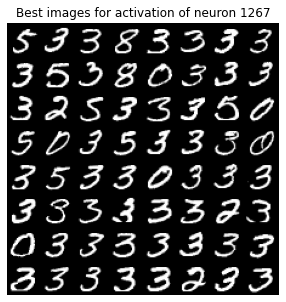

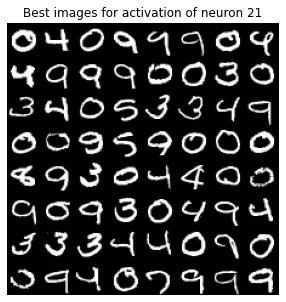

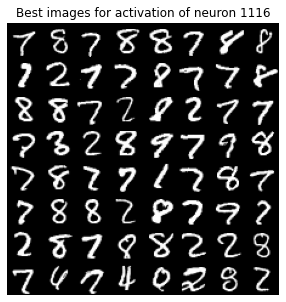

In [32]:
neurons = np.random.choice(1568, 10)
for neuron in neurons:
    indexes = activation[:,neuron].argsort()[-64:]
    imshow = np.zeros((8*28, 8*28))
    for _, im in enumerate(x_test[indexes]):
        i,j = _//8, _%8
        imshow[28*i:28*(i+1), 28*j:28*(j+1)] = im[0]
    plt.figure(figsize=(5,5))
    plt.imshow(imshow, cmap='gray', vmin=0, vmax=imshow.max())
    plt.title('Best images for activation of neuron {}'.format(neuron))
    plt.axis('off')
    plt.show()

To be exhaustive, we could also display the images that activate the least these same neurons. Nevertheless, in practice, the number of images that activate a neuron is quite small. This can be seen by viewing the histogram of the values taken by a neuron for the whole dataset. Note that it uses a ReLU activation, that is why we it makes sense to only consider big activation values.

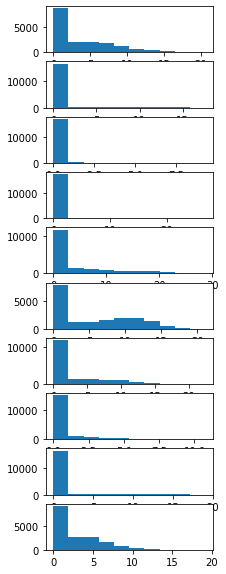

In [33]:
fig, axs = plt.subplots(10, figsize=(3, 10))
for i, neuron in enumerate(neurons):
    axs[i].hist(activation[:,neuron])
#indexes = activation[:,neurons]


Let's try to do the same for the pre-trained network on ImageNet. To do this, we need more data than our single dog image, so we'll download a part of ImageNet: a hundred images labeled cat, and another hundred labeled dog.

In [34]:
from tqdm.notebook import tqdm
cat_images_url = "http://image-net.org/api/text/imagenet.synset.geturls?wnid=n02121808"
t = tqdm(total=100)
cat_images = []
for line in urllib.request.urlopen(cat_images_url):
    url = line.decode('utf-8')
    filename = url.split('/')[-1]
    try:
        image = Image.open(urllib.request.urlopen(url, timeout=.5)) # if you have a very bad internet connection you should increase the timeout... and wait longer :)
        cat_images.append(preprocess(image).numpy()) 
    except: continue
    t.update(1)
    if len(cat_images)>=100:
        break
t.close()
cat_tensor = torch.tensor(cat_images)

dog_images_url = "http://image-net.org/api/text/imagenet.synset.geturls?wnid=n02084071"
t = tqdm(total=100)
dog_images = []
for line in urllib.request.urlopen(dog_images_url):
    url = line.decode('utf-8')
    filename = url.split('/')[-1]
    try:
        image = Image.open(urllib.request.urlopen(url, timeout=.5)) # if you have a very bad internet connection you should increase the timeout... and wait longer :)
        dog_images.append(preprocess(image).numpy()) 
    except: continue
    t.update(1)
    if len(dog_images)>=100:
        break
t.close()
dog_tensor = torch.tensor(dog_images)

Now that these images are downloaded, we can pass them together on the pretrained network, and then pick those that maximize the activation of certain neurons once all the convolutions have been computed.

In [35]:
pictures_tensor = torch.cat([cat_tensor, dog_tensor], dim=0)
activation = nn.Flatten()(model.classifier[0](model.avgpool(model.features(pictures_tensor)))).detach().numpy()
activation.shape

(200, 9216)

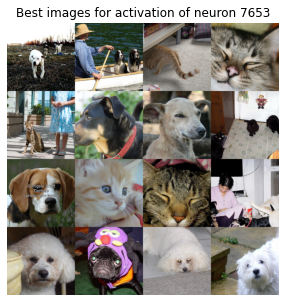

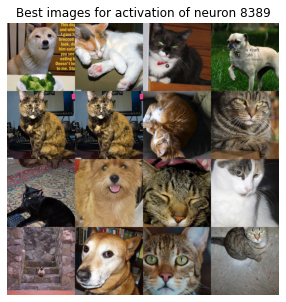

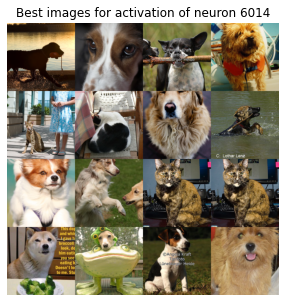

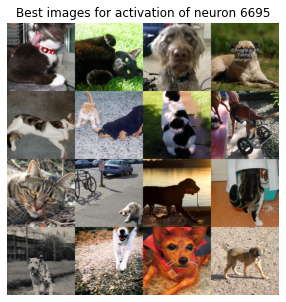

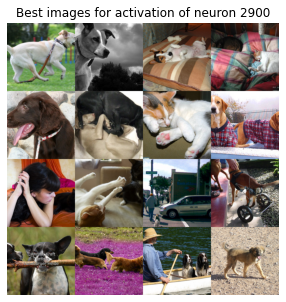

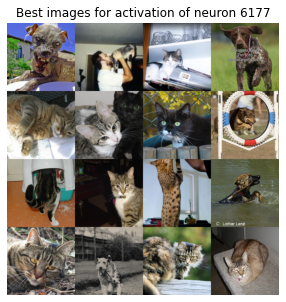

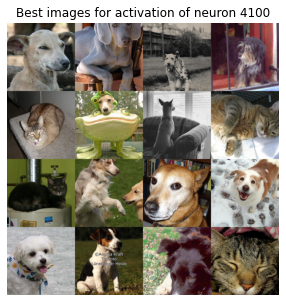

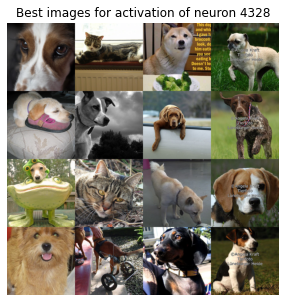

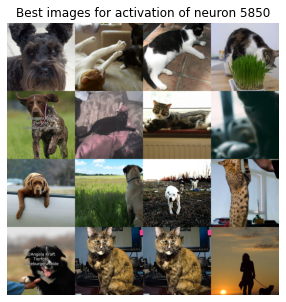

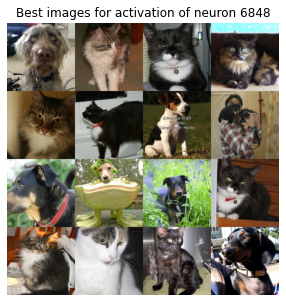

In [36]:
neurons = np.random.choice(9216, 10)
for neuron in neurons:
    indexes = activation[:,neuron].argsort()[-16:]
    imshow = np.zeros((3, 4*224, 4*224))
    for _, im in enumerate(pictures_tensor[indexes]):
        i,j = _//4, _%4
        imshow[:, 224*i:224*(i+1), 224*j:224*(j+1)] = im
    imshow = imshow.transpose((1,2,0))
    imshow = (imshow-imshow.min((0,1)))/(imshow.max((0,1))-imshow.min((0,1)))
    plt.figure(figsize=(5,5))
    plt.imshow(imshow)
    plt.title('Best images for activation of neuron {}'.format(neuron))
    plt.axis('off')
    plt.show()

You can execute the cell again to see other intermediate features.

Again, images from different labels can activate the same neuron. But we can find similarities between these images. We can then understand what is the specificity of the image that led to specifically activate a neuron. This allows us to understand which features the network uses to classify the images (although these features can be complex). For example, the color of the animal, or the shape of the ears. But we should keep in mind that these features are not only used to categorize cats and dogs, but 1000 different labels. So we cannot hope to understand all of the intermediate features using only results on cat and dog pictures...

To have a better chance of understanding, we would have to download many more, more diverse images. For the execution time, I limited this notebook to dogs and cats, but it would be interesting for example to see if a feature has filtered the living beings, or on the contrary, if a feature is activated by certain living beings and certain objects: in this case, we can look for their common point.

Images of ImageNet dataset can be downloaded for free very easily using http://image-net.org.

In practice, this technique is quite powerful. On the one hand, because the limitation we have in this notebook is not present in practice (access to training data is simpler); this is why we have rather detailed the example with MNIST. On the other hand, through the visualization of images, human intelligence is used to understand the neural network. 

# Embedding the codes with t-SNE

We will try to go further in the analysis of the vector of intermediate features provided by the convolutional part of the neural network. As explained above, this vector can be considered as a vector of image features used later for the classification. Then one can try to represent the space in which all the images are represented by this vector. In order to visualize this very large space, we are going to reduce its dimension to 2, using a technique seen in class: t-SNE.

To reduce the execution time, let us randomly take a few MNIST images. Anyway, it will be more readable not to visualize all the 17500 test images of MNIST.

In [37]:
from sklearn.manifold import TSNE
X = x_test[np.random.choice(x_test.shape[0], 1000)]
activation = net.classifier[0](net.avgpool(net.features(X))).detach().numpy()
activation_embedded = TSNE(n_components=2).fit_transform(activation)
activation_embedded.shape


(1000, 2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


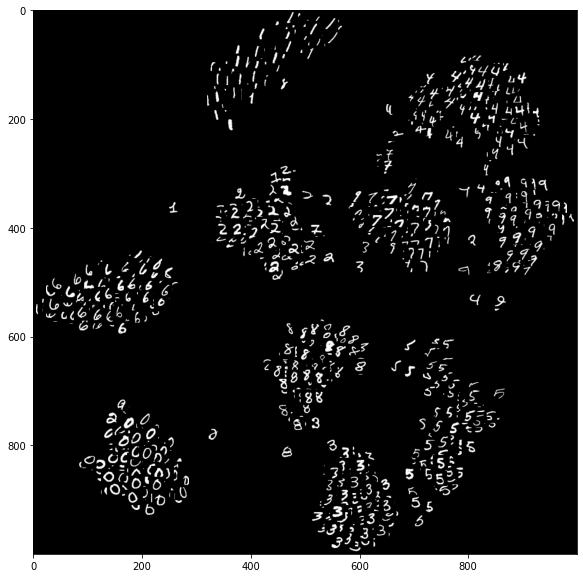

In [38]:
activation_embedded = 14+(1000-28)*(activation_embedded-activation_embedded.min(0))/(activation_embedded.max(0)-activation_embedded.min(0))
embedding = np.zeros((1000, 1000, 3))
for (x, y), image in zip(activation_embedded, X):
    x, y = int(x), int(y)
    w = 28
    embedding[x-w//2:x+w//2, y-w//2:y+w//2] = image.numpy().transpose((1,2,0))
embedding = (embedding-embedding.min(0))/(embedding.max(0)-embedding.min(0))
plt.figure(figsize=(10,10))
plt.imshow(embedding)
plt.show()

We note that from the representation, the numbers seem to be separable quite simply once the network has picked up the features of the images. But we have better than that here. We know which classes are likely to be confused. In my case (remind that the training of the network was done locally, the reader could have another case than mine), I see that the digits 4 and 9 are very close in this representation, as well as the digits 3 and 5. On the contrary, the 1s form a fairly united group, quite distant from the others. By looking at the distance between two classes, we can also try to understand the errors of the network, and the features.

It is easy to draw the same graph with cat and dog pictures from ImageNet data.

In [39]:
from sklearn.manifold import TSNE
activation = nn.Flatten()(model.classifier[0](model.avgpool(model.features(pictures_tensor)))).detach().numpy()
activation_embedded = TSNE(n_components=2).fit_transform(activation)
activation_embedded.shape


(200, 2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


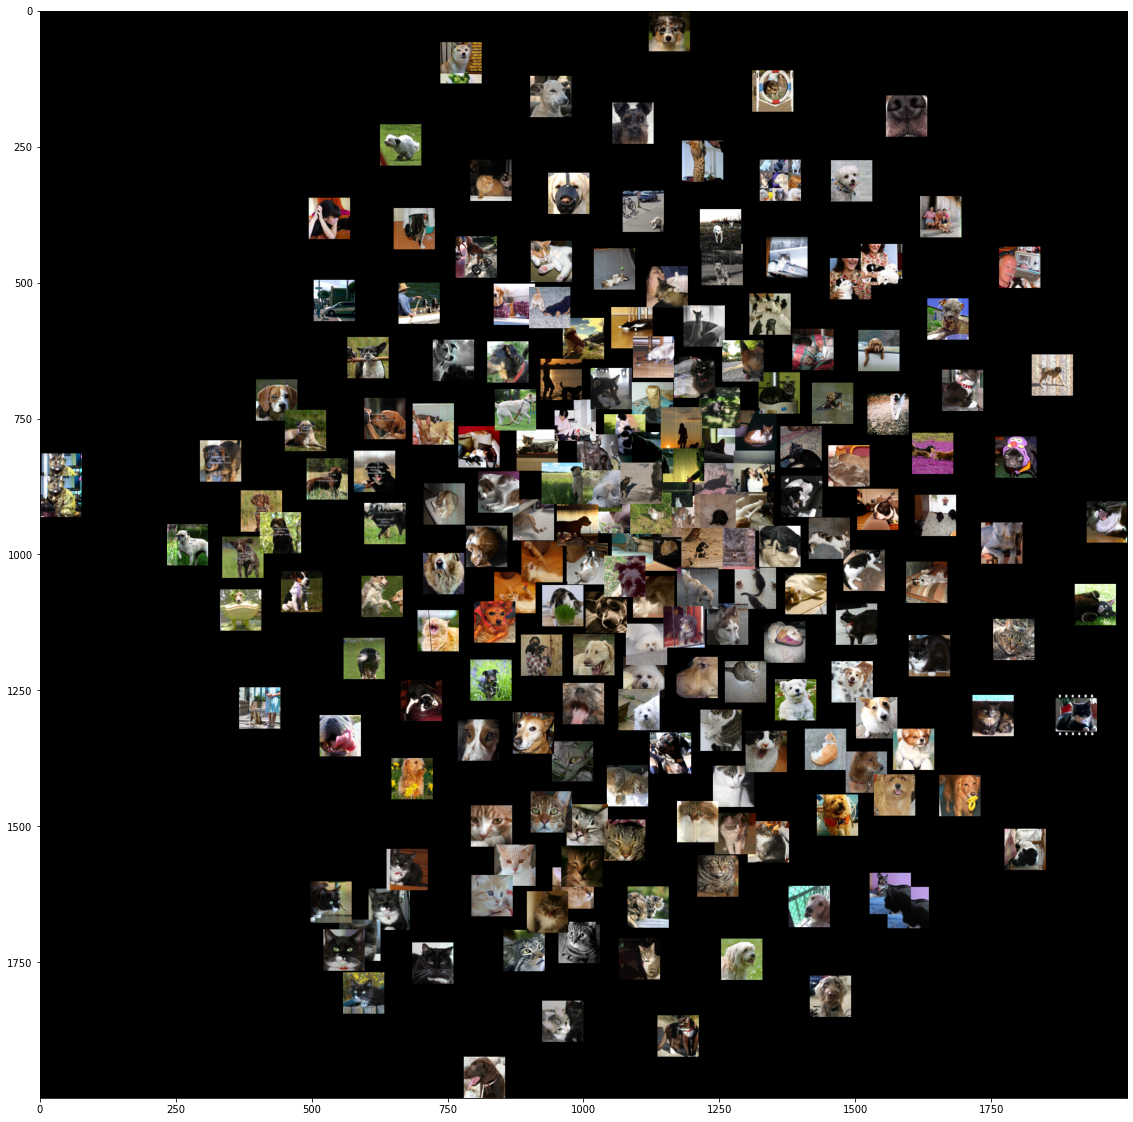

In [40]:
activation_embedded = 38+(2000-76)*(activation_embedded-activation_embedded.min(0))/(activation_embedded.max(0)-activation_embedded.min(0))
embedding = np.zeros((2000, 2000, 3))
pictures = pictures_tensor.numpy().transpose((0,2,3,1))
pictures = (pictures - pictures.min((0,1,2)))/(pictures.max((0,1,2)) - pictures.min((0,1,2)))
for (x, y), pic in zip(activation_embedded, pictures):
    x, y = int(x), int(y)
    w = 76
    embedding[x-w//2:x+w//2, y-w//2:y+w//2] = np.array(Image.fromarray(np.uint8(pic*255)).resize((76,76)))
embedding = (embedding-embedding.min(0))/(embedding.max(0)-embedding.min(0))
plt.figure(figsize=(20,20))
plt.imshow(embedding)

The analysis is less simple in this case. The downloaded images are not necessarily the same at each execution, so this graph may differ. If you have a case close to mine, you can see locally that two close images are a bit similar: dogs of the same color, or a zoom on a cat's head... We understand the information extracted by convolutions from the images, to create features. But for example, here, dogs and cats are not easily separable. This may be a bias from the 2D repreesentation.

To give you an idea of what it can looks like when applied to a larger dataset: https://cs.stanford.edu/people/karpathy/cnnembed/cnn_embed_1k.jpg

Even larger: https://cs.stanford.edu/people/karpathy/cnnembed/cnn_embed_6k.jpg

On this second link (a long image to generate), it is interesting to note that pictures are globally gathered when they have a common global color. The background, even if it doesn't give a direct indication of what the photo represents, remains an interesting feature. With a deeper look, it is laso possible to make hypothesis of other features learned with convolutions.

It is this type of embedding that allows us to formulate hypotheses about how the neural network learned globally.


# Analyze the occlusion sensitivity of a neural network

In this part, we will explore a new idea, developped in the paper *Visualizing and Understanding Convolutional Networks* (https://arxiv.org/pdf/1311.2901.pdf). Typically, on images of dogs or cats, we can guess that the part of the image that best allows the network to classify it correctly is the head of the animal. It is in any case what seems most intuitive to us. But is it the case all the time? Would the pre-trained network on ImageNet be able to recognize a dog, if you hide its head but the rest of its body stays? And would the one on MNIST be able to recognize an 9 if you hide part of it?

We will try to see if the network continues to learn despite the fact that a part of the image is hidden. By doing this and hiding several parts, we will be able to create a heat map indicating where the element that helps the network to find the right label of an image is. Let's try on the dog image previously used.

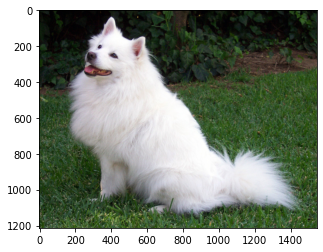

In [41]:
plt.figure()
plt.imshow(input_image)
plt.show()

In [42]:
occluded = torch.cat([input_tensor.clone().detach().unsqueeze(0) for _ in range(16*16)])
for i in range(occluded.shape[0]):
    x, y = i//16, i%16
    x = 224*(2*x+1)//(2*16)
    y = 224*(2*y+1)//(2*16)
    w = 36
    occluded[i,:,x-w//2:x+w//2,y-w//2:y+w//2] = 0


In [43]:
images = occluded.numpy().transpose((0,2,3,1))
images = (images-images.min((0,1,2)))/(images.max((0,1,2))-images.min((0,1,2)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


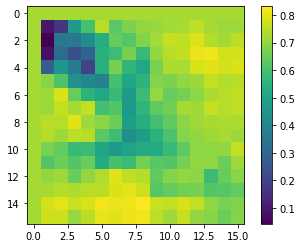

In [44]:
idx = model(input_tensor.unsqueeze(0)).argmax()
scores = F.softmax(model(occluded))[:,idx].detach().numpy()

cm=plt.imshow(scores.reshape(16,16))
plt.colorbar(cm)
plt.show()

The network's confidence in its usual answer can decrease greatly depending on the area of the image that has been captured. It can go down to less than 10%. Let's look at what the worst image looks like:

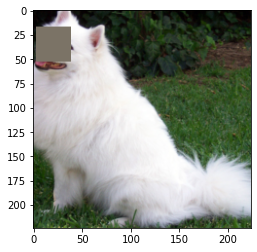

In [45]:
plt.imshow(images[scores.argmin()])

We have here an element that allows us to understand how the AlexNet network trained on ImageNet manages to classify this dog. It detects the head of the dog. This seems consistent with our experience, but we have a fairly powerful tool, because we can understand which area of the image was best used by the neural network for the classification result.

What might this mean for the network trained on MNIST? Let's take the image of a 9.

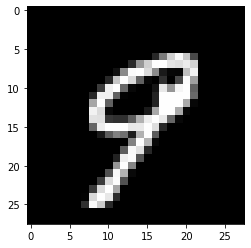

In [66]:
x_ = x_test[np.random.choice(np.where(y_test==9)[0])]
plt.imshow(x_[0], cmap='gray')

In [68]:
occluded = torch.cat([torch.Tensor(x_).unsqueeze(0) for _ in range(8*8)])
for i in range(occluded.shape[0]):
    x, y = i//8, i%8
    x = 28*(2*x+1)//(2*8)
    y = 28*(2*y+1)//(2*8)
    w = 8
    occluded[i,:,x-w//2:x+w//2,y-w//2:y+w//2] = 128


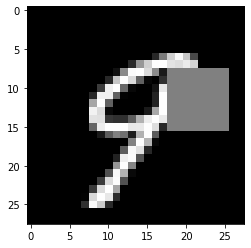

In [69]:
images = occluded.numpy().transpose((0,2,3,1))
images = (images-images.min((0,1,2)))/(images.max((0,1,2))-images.min((0,1,2)))
plt.figure()
plt.imshow(images[30,:,:,0], cmap='gray')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


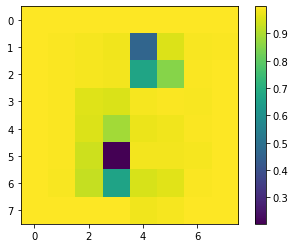

In [70]:
idx = net(torch.Tensor(x_).unsqueeze(0)).argmax()
scores = F.softmax(net(occluded))[:,idx].detach().numpy()

plt.figure()
cm=plt.imshow(scores.reshape(8,8))
plt.colorbar(cm)
plt.show()

The degree of confidence on prediction "9" is decreased quite significantly over a certain area. Let's see why:

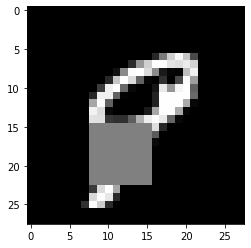

In [71]:
plt.figure()
plt.imshow(images[scores.argmin(),:,:,0], cmap='gray')
plt.show()

We learned that the gray zone is in fact an essential element for prediction 9.

If on the shown examples, it didn't work pretty well, you can re-run this part of the code to see another one.

# Conclusion

As a conclusion, there are a lot of techniques to visualize a function hidden in a neural network, at different scales.

At a neural scale, it is possible to visualize the weights of a function between two layers, for example a convolution, to understand its behaviour. We can make a parallel between this approach and looking at weights of an SGD classifier.

At a layer scale, we can visualize layer activations on a specific input, or select inputs that maximise an activation. 

At a more global scale, we can analyse the intermediate features computed with convolutions, with t-SNE embeddings for example. It allows us to have a better understanding of these features, that is the basis of the hidden function of AlexNet for example.

Last but not least, at the neural network scale, we can analyze the occlusion sensitivity of a neural network, in order to have a global understanding of how the classification is done. This method has the advantage of being very easy to visualize, with a heatmap of the image.

All of these methods are quite easy to do, even though most of them need to have access to layers of the neural network. That can be an inconvenient for more complex neural networks. Still, the last method is very easy to use, and quite universal, as you just need to modify inputs and to evaluate the model on these inputs.

As a proof that it is easy to do in practice, we tried to apply these methods on the typical dataset MNIST, and with a deliberately complex neural network: it is still possible to make assumptions on how the network worked, even with one that is trained locally (so not the same for me and the reader).

We hope that it will show the reader that one can visualize their own complex neural network with simple tools - and some human intelligence.